In [6]:
import os
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import ops
from keras import layers

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [ ]:
"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

"""
## Define the VAE as a `Model` with a custom `train_step`
"""


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = ops.mean( ops.sum(keras.losses.mean_squared_error(data, reconstruction),axis=(1, 2),))

            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


"""
## Train the VAE
"""

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.summary()

In [5]:
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - kl_loss: 1.0341 - loss: 68.6698 - reconstruction_loss: 67.6357
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - kl_loss: 2.3466 - loss: 46.7194 - reconstruction_loss: 44.3728
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - kl_loss: 3.6765 - loss: 41.9856 - reconstruction_loss: 38.3091
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - kl_loss: 3.9907 - loss: 40.3590 - reconstruction_loss: 36.3683
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 4.1507 - loss: 39.7012 - reconstruction_loss: 35.5504
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 4.2776 - loss: 39.3040 - reconstruction_loss: 35.0264
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - kl_loss: 4.3494 - loss: 38.9942 - reconstruction_loss: 34.6448
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 4.3988 - loss: 38.7005 - reconstruction_loss: 34.3017
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms

In [ ]:
"""
## Display a grid of sampled digits
"""

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
    
    
"""
## Display how the latent space clusters different digit classes
"""


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

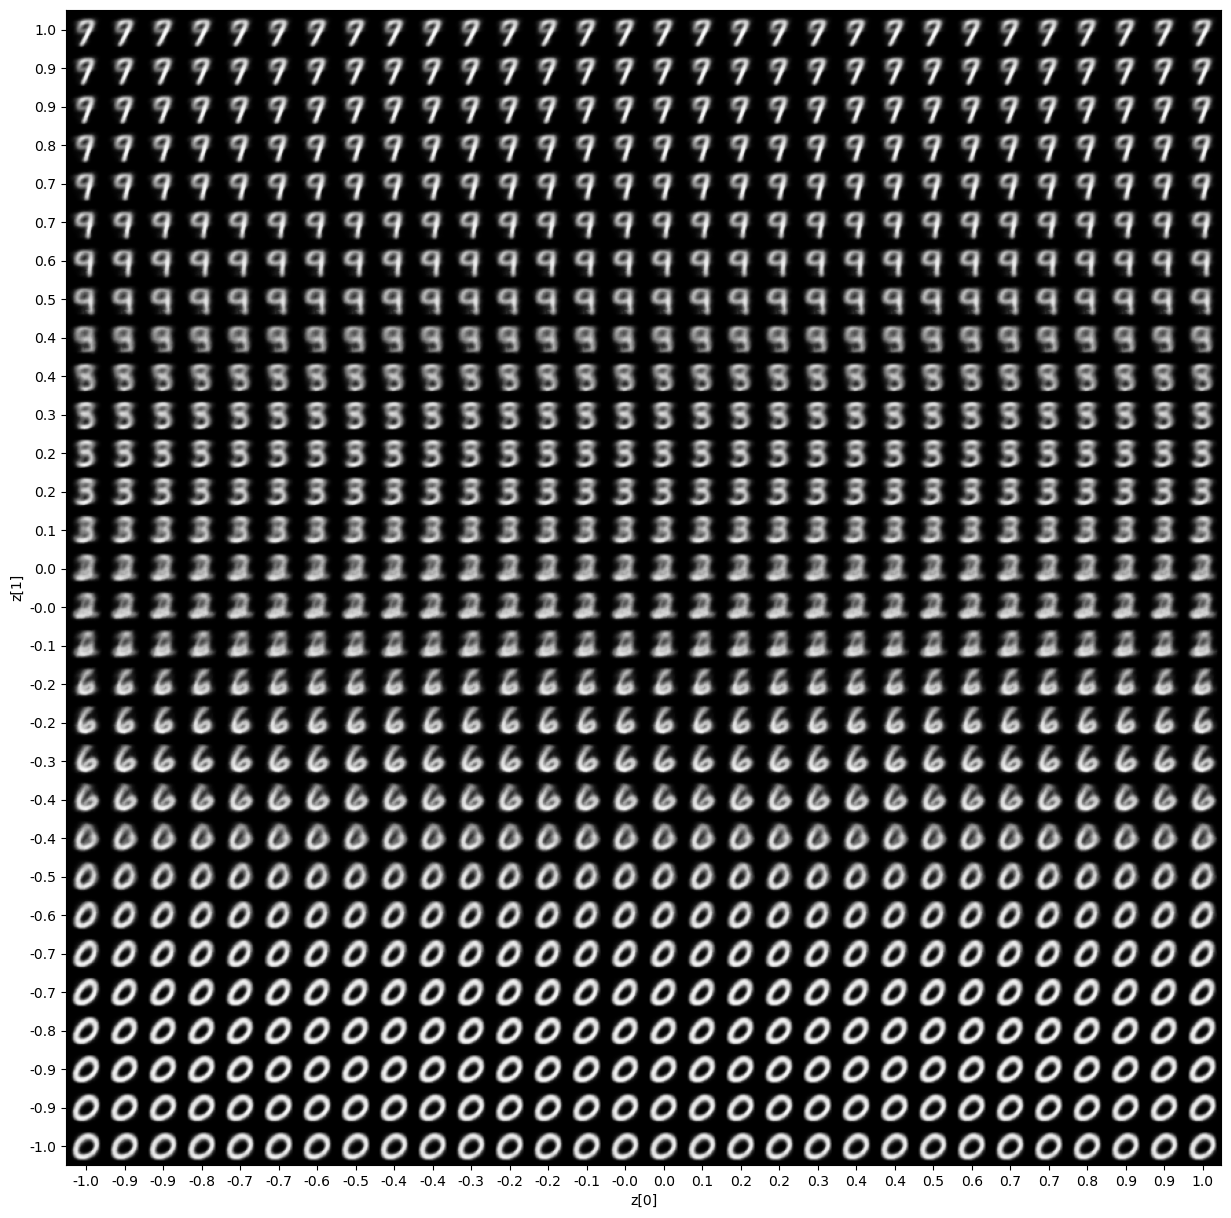

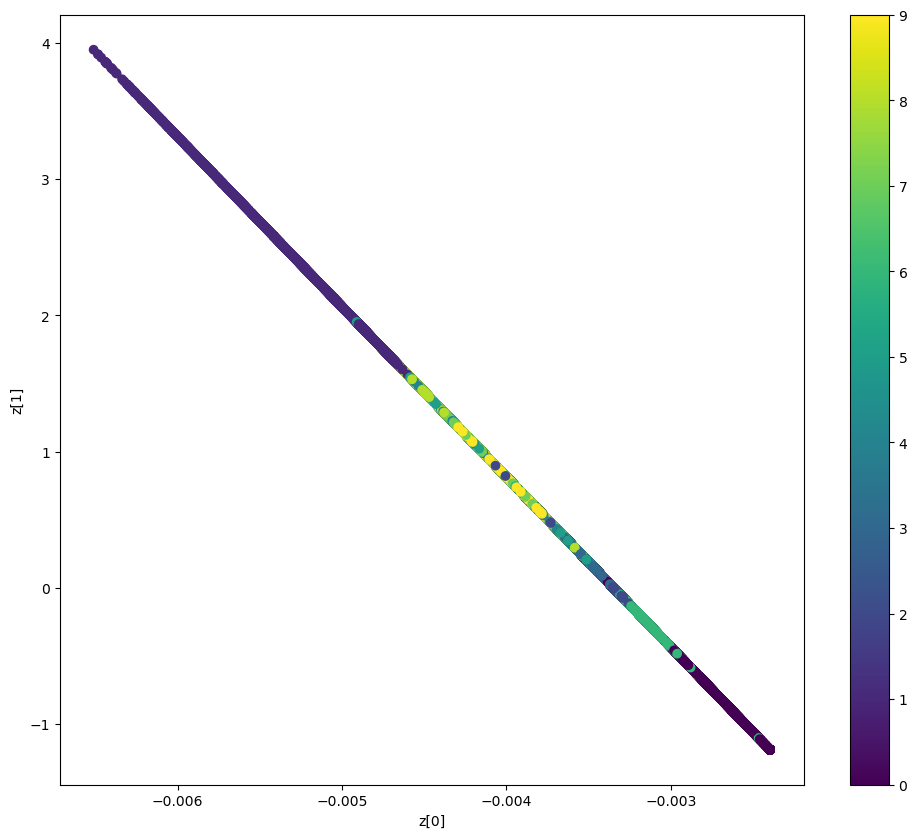

In [4]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255


plot_latent_space(vae)

plot_label_clusters(vae, x_train, y_train)